In [1]:
import numpy as np
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

2.3.1 0.18.1
Files already downloaded and verified
Running on cuda:4
GT label is 2. 
Onehot label is 2.
Dummy label is 0.
0, 451.2135925292969
30, 13.676374435424805
60, 6.520134449005127
90, 3.2126448154449463
120, 1.9706943035125732
150, 1.3229378461837769
180, 0.9576412439346313
210, 0.7126080393791199
240, 0.537339985370636
270, 0.40787866711616516
300, 0.31809064745903015
330, 0.24634839594364166
360, 0.1943030208349228
390, 0.1522146463394165
420, 0.1207369863986969
450, 0.09898117184638977
480, 0.08288288861513138
510, 0.06850913912057877
540, 0.05741804838180542
570, 0.049852460622787476


/home/dawitkr/miniconda3/envs/flwr-exp/lib/python3.9/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


600, 0.04228796064853668
630, 0.03558354452252388
660, 0.03025316260755062
690, 0.026336178183555603
720, 0.02316386252641678
750, 0.0202871635556221
780, 0.017966939136385918
810, 0.016120029613375664
840, 0.014545856975018978
870, 0.013224545866250992
idx = 898, len = 11825
Dummy label is 0.
Files already downloaded and verified
Running on cuda:4
GT label is 2. 
Onehot label is 2.
Dummy label is 9.
0, 794.1582641601562
30, 123.50809478759766
60, 109.0311279296875
90, 60.58743667602539
120, 53.739952087402344
150, 51.16699981689453
180, 47.860679626464844
210, 44.88259506225586
240, 41.5370979309082
270, 38.784568786621094
300, 35.918704986572266
330, 33.48065948486328
360, 31.131250381469727
390, 29.23000144958496
420, 27.622922897338867
450, 26.32076644897461
480, 25.254392623901367
510, 24.287961959838867
540, 23.33579444885254
570, 22.539182662963867
600, 21.791772842407227
630, 20.907840728759766
660, 20.345399856567383
690, 19.838964462280273
720, 19.415130615234375
750, 18.9522

/tmp/ipykernel_31464/167164759.py:150: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


idx = 898, len = 17986
Dummy label is 2.


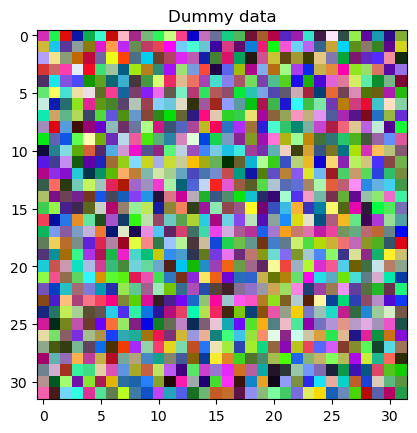

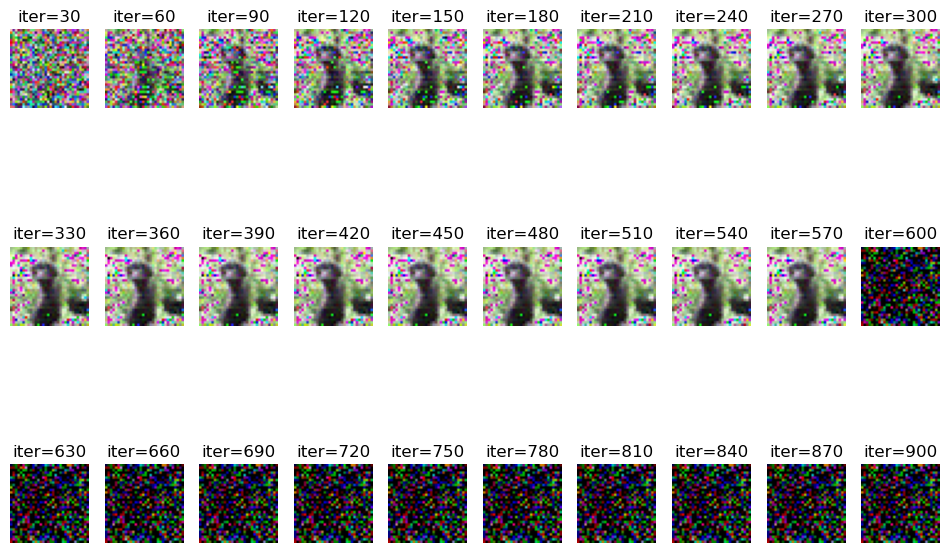

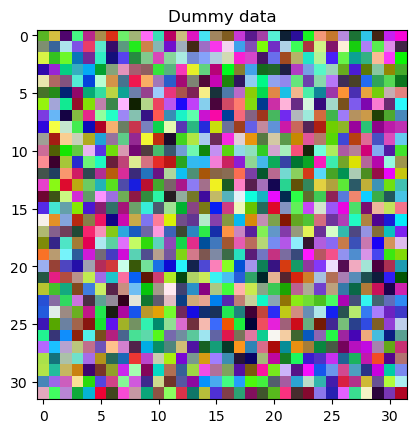

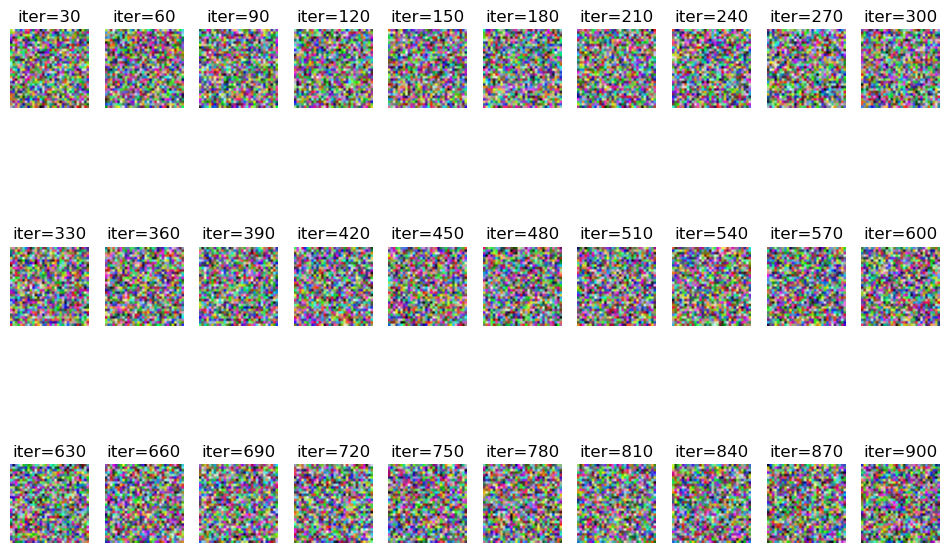

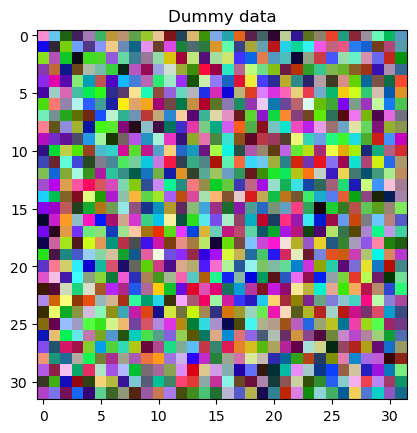

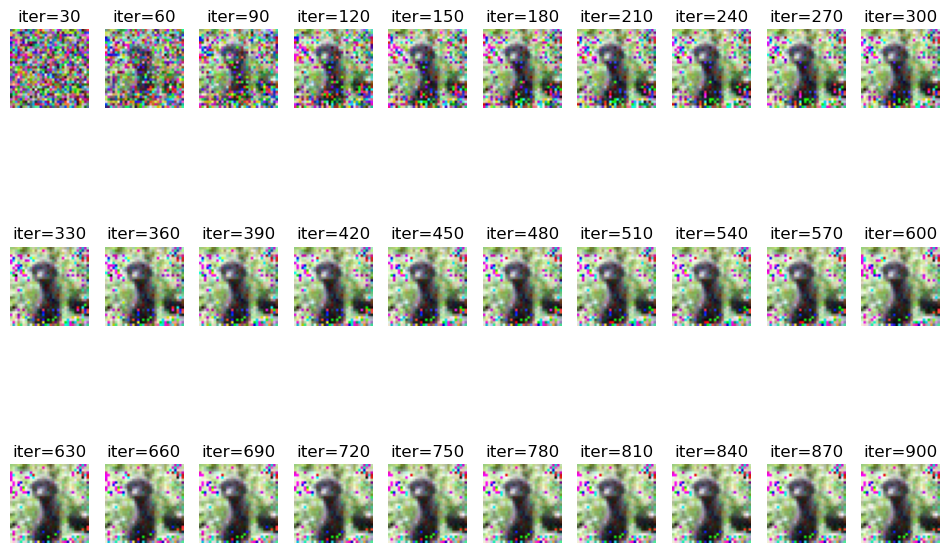

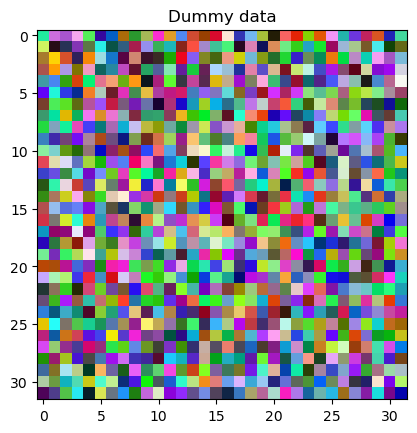

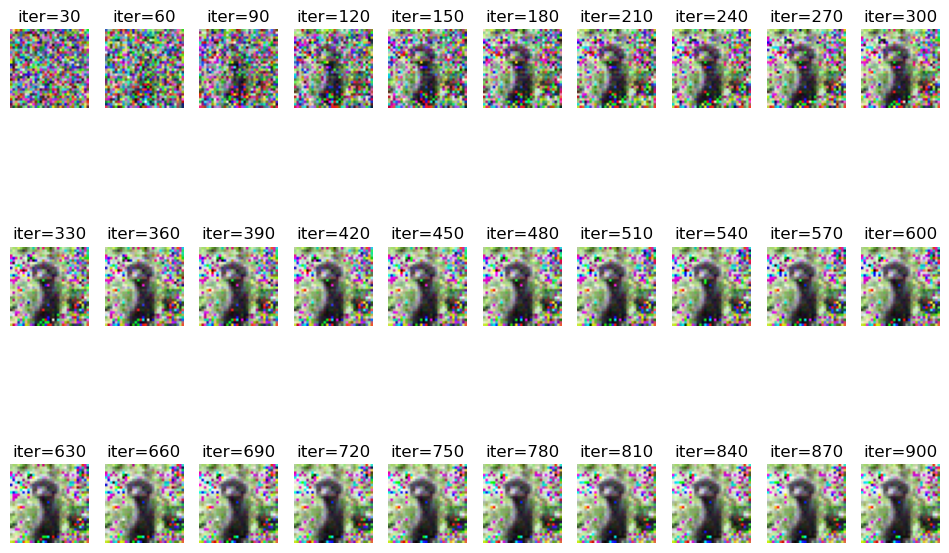

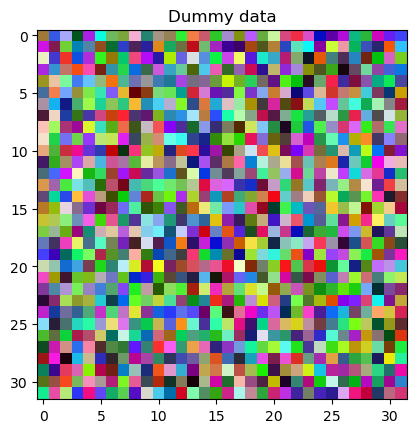

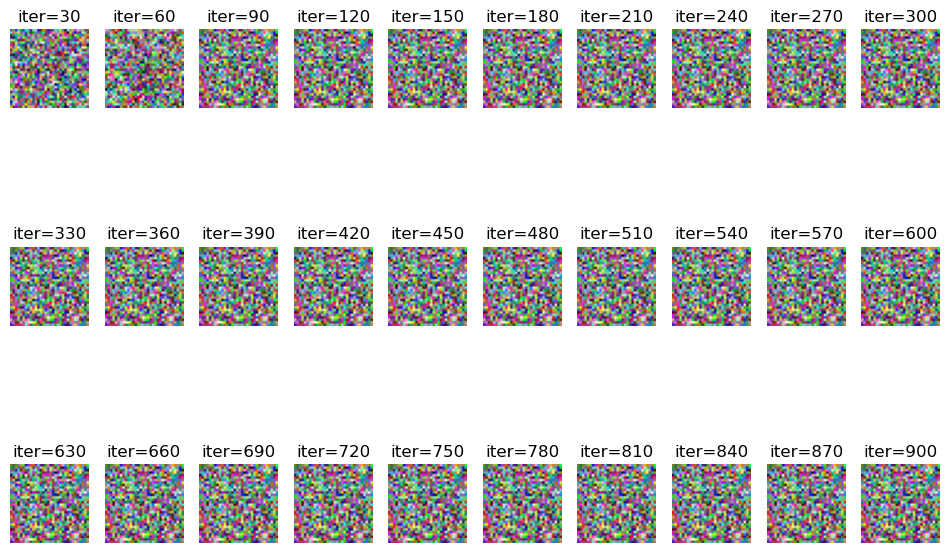

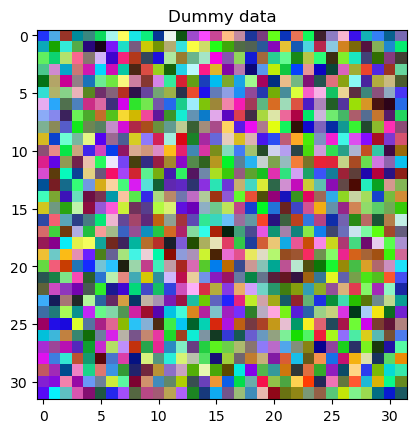

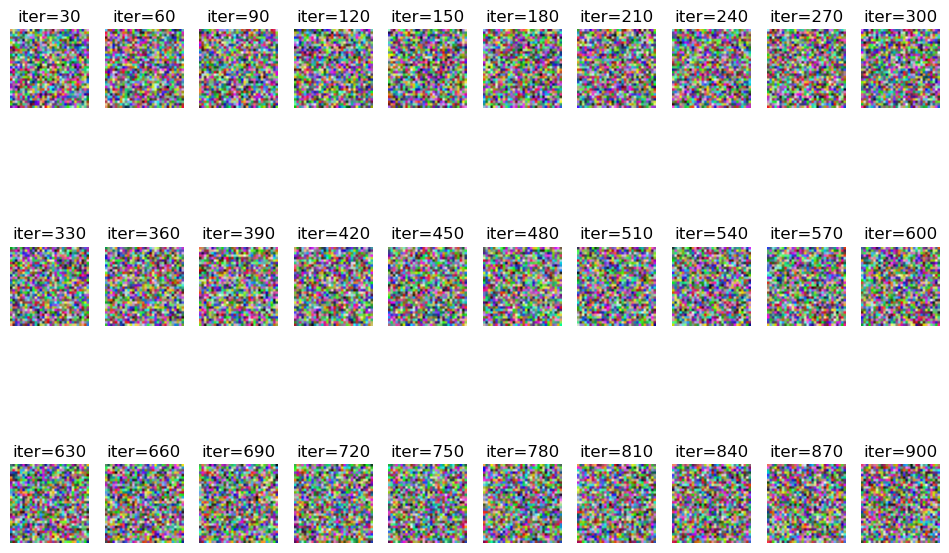

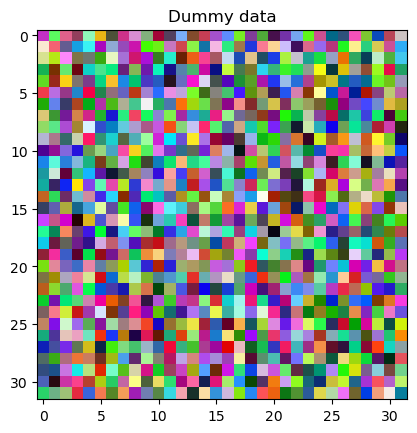

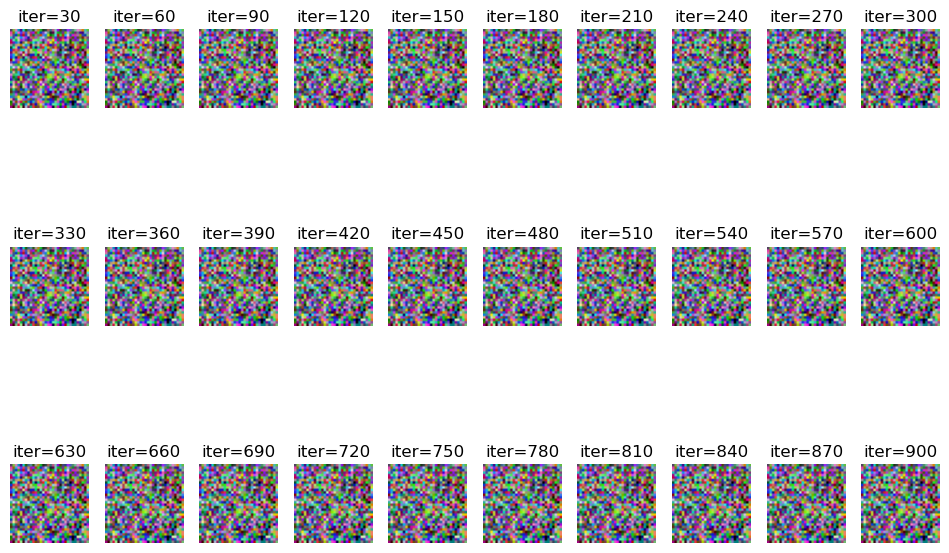

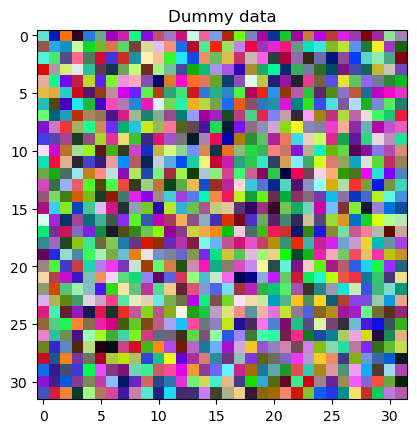

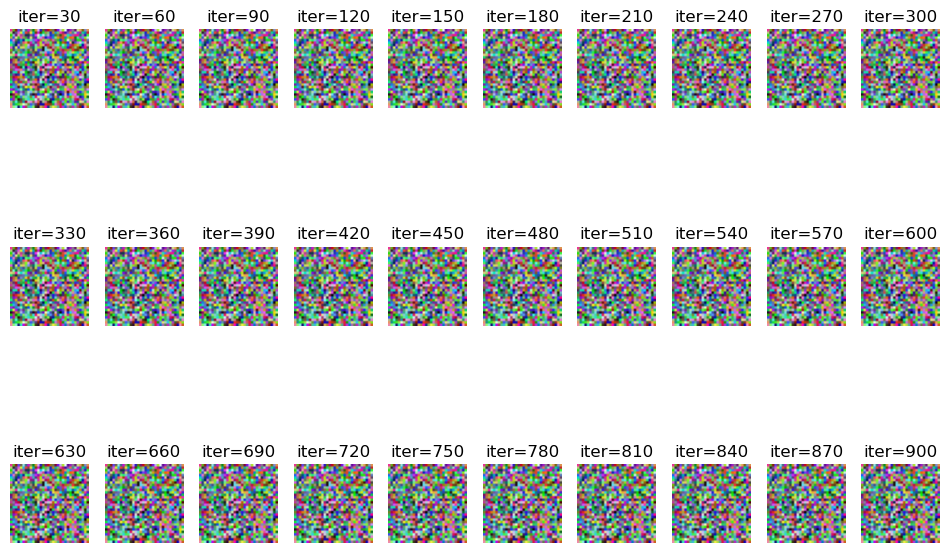

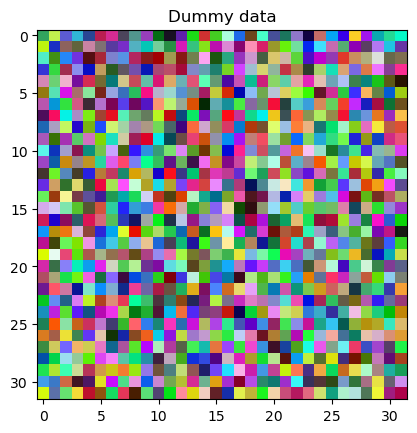

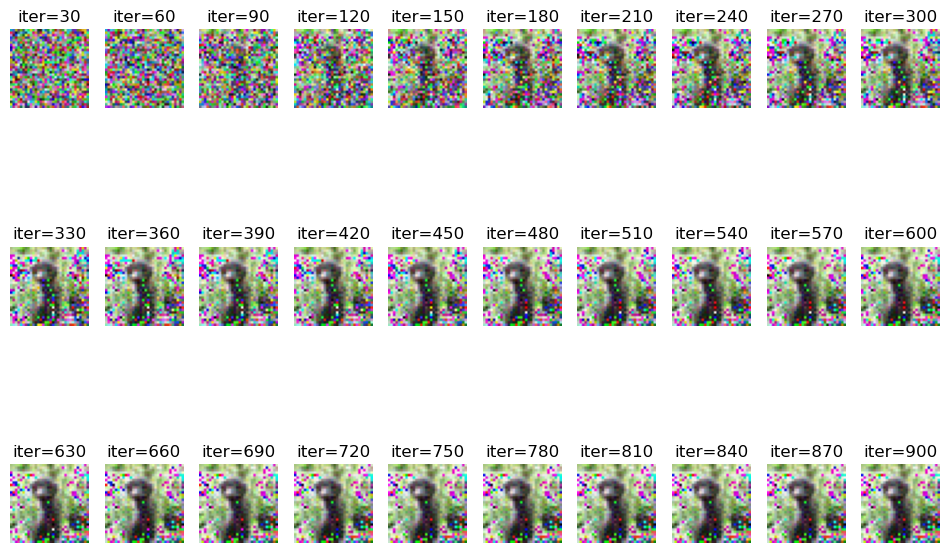

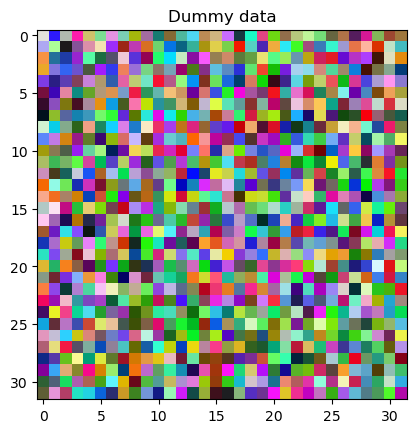

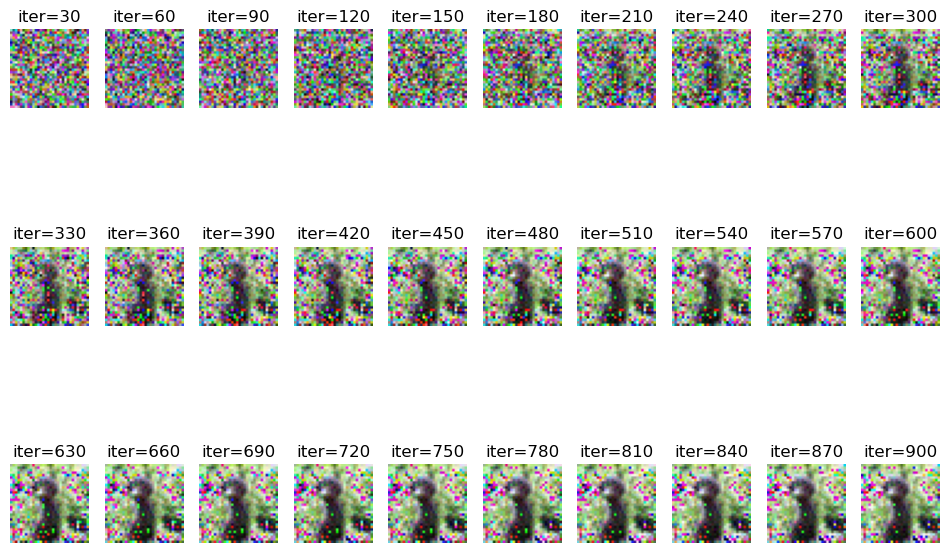

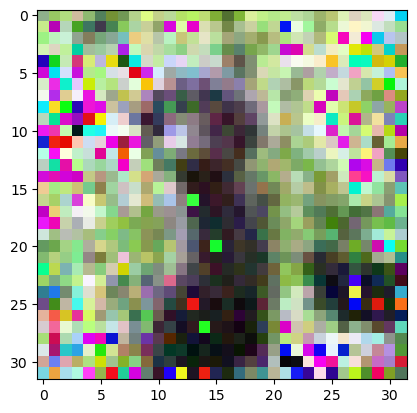

In [2]:
print(torch.__version__, torchvision.__version__)
for tid in range(10):
    interval = 30
    class_num = 10
    protected_layers = []  # No specific layers to protect initially
    dst = datasets.CIFAR10("~/.torch", download=True)
    tp = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])
    tt = transforms.ToPILImage()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:4"  # Changed to cuda:0 for general usage
    print("Running on %s" % device)

    def label_to_onehot(target, num_classes=class_num):
        target = torch.unsqueeze(target, 1)
        onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
        onehot_target.scatter_(1, target, 1)
        return onehot_target

    def cross_entropy_for_onehot(pred, target):
        return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

    def weights_init(m):
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)

    class LeNet(nn.Module):
        def __init__(self):
            super(LeNet, self).__init__()
            act = nn.Sigmoid
            self.body = nn.Sequential(
                nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
                act(),
            )
            self.fc = nn.Sequential(
                nn.Linear(768, class_num)
            )

        def forward(self, x):
            out = self.body(x)
            out = out.view(out.size(0), -1)
            out = self.fc(out)
            return out

    net = LeNet().to(device)

    net.apply(weights_init)
    criterion = cross_entropy_for_onehot

    img_index = 55
    gt_data = tp(dst[img_index][0]).to(device)
    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=class_num)
    plt.imshow(tt(gt_data[0].cpu()))
    plt.title("Ground truth image")
    print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    out = net(gt_data)
    y = criterion(out, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())

    def mask_gradients(dy_dx, exposure_ratio=3/3):
        flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
        total_params = len(flattened_grads)
        exposed_params = int(total_params * exposure_ratio)

        mask = torch.zeros(total_params, device=flattened_grads.device)
        mask[:exposed_params] = 1
        mask = mask[torch.randperm(total_params)]

        masked_grads = []
        start = 0
        for g in dy_dx:
            numel = g.numel()
            g_flat = g.view(-1)
            masked_g_flat = g_flat * mask[start:start+numel]
            masked_grads.append(masked_g_flat.view_as(g))
            start += numel

        return tuple(masked_grads)

    dy_dx = mask_gradients(dy_dx)

    original_dy_dx = list((_.detach().clone() for _ in dy_dx))

    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

    history = []
    losses = []
    for iters in range(30*interval):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            dummy_dy_dx = mask_gradients(dummy_dy_dx)

            grad_diff = 0
            grad_count = 0

            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()

            grad_diff.backward()
            losses.append(grad_diff.item())
            return grad_diff

        optimizer.step(closure)
        if iters % interval == 0:
            print(f"{iters}, {losses[iters]}")
        history.append(tt(dummy_data[0].cpu()))

    plt.figure(figsize=(12, 8))
    for i in range(30):
        ite_num = i * interval + interval - 1
        plt.subplot(3, 10, i + 1)
        plt.imshow(history[ite_num])
        plt.title("iter=%d" % (ite_num+1))
        plt.axis('off')

    filename = 'CIFAR'+str(class_num)+'_'+ str(30*interval) + 'ite_' + str(protected_layers) + '_' +'.png'
    plt.savefig(filename)

    plt.figure()
    loss = min(losses[0:interval * 30 - 1])
    idx = losses.index(loss)
    print(f"idx = {idx}, len = {len(losses)}")
    plt.imshow(history[idx])
    filename = 'single_' + filename
    plt.savefig(filename)

    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())


GT label is 2. 
Onehot label is 2.


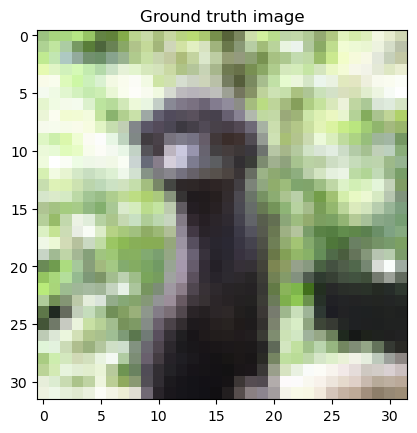

In [3]:
plt.imshow(tt(gt_data[0].cpu()))
# file_gt = "gt.png"
# plt.savefig(file_gt)
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())